# Rent price prediction for apartments in Cluj Napoca
First of all I need to import all the modules that I'm going to use and the dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('scraping_env/webscrapy/webscrapy/rent_price_results.csv', thousands='.',decimal=',')
df.head()

,currency,floor,neighborhood,new_building,partitioning,price,rooms,space
0,EUR / lună,Etaj 5/7,"Cluj-Napoca, zona Central",NaN,Semidecomandat,400.0,2 camere,58.5 mp utili
1,EUR / lună,Etaj 8/10,"Cluj-Napoca, zona Mănăştur",NaN,Semidecomandat,280.0,2 camere,52 mp utili
2,EUR / lună,Etaj 3/3,"Cluj-Napoca, zona Zorilor",Bloc nou,Semidecomandat,400.0,3 camere,84 mp utili
3,EUR / lună,Parter/4,"Cluj-Napoca, zona Gheorgheni",NaN,Semidecomandat,400.0,3 camere,65 mp utili
4,EUR / lună,Etaj 1/2,"Cluj-Napoca, zona Zorilor",Bloc nou,Decomandat,420.0,2 camere,55 mp utili


In [3]:
df.tail()

,currency,floor,neighborhood,new_building,partitioning,price,rooms,space
5000,EUR / lună,Etaj 2/3,"Cluj-Napoca, zona Europa",Bloc nou,Decomandat,400.0,2 camere,55 mp utili
5001,EUR / lună,Parter,"Cluj-Napoca, zona Central",NaN,Semidecomandat,380.0,2 camere,47 mp utili
5002,EUR / lună,Parter/2,"Cluj-Napoca, zona Ultracentral",NaN,Semidecomandat,650.0,3 camere,72 mp utili
5003,EUR / lună,Etaj 8/11,"Cluj-Napoca, zona Gheorgheni",Bloc nou,Semidecomandat,620.0,3 camere,75 mp utili
5004,EUR / lună,Etaj 1/2,"Cluj-Napoca, zona Bulgaria",Bloc nou,Semidecomandat,330.0,3 camere,55 mp utili


In [4]:
df.shape

(5005, 8)

In [5]:
df.describe()

,price
count,5003.000000
mean,445.388967
std,181.648170
min,90.000000
25%,350.000000
50%,400.000000
75%,500.000000
max,2550.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5005 entries, 0 to 5004
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   currency      5003 non-null   object 
 1   floor         5004 non-null   object 
 2   neighborhood  5005 non-null   object 
 3   new_building  1545 non-null   object 
 4   partitioning  4939 non-null   object 
 5   price         5003 non-null   float64
 6   rooms         5005 non-null   object 
 7   space         5005 non-null   object 
dtypes: float64(1), object(7)
memory usage: 312.9+ KB


From the above informations, at the first glance, we can see that we may have some outliers from the min max values(90, 2550) of the rent prices. For the features 'currency', 'floor', 'price' and especially for 'neighborhood' and 'new building' we can see that there are some null values. Another importat aspect is that in exploratory data analysis we have to change the data types of some of the features. 

## 1. Data Cleaning and Exploratory Data Analysis

In my first step I want to clean the data from my dataset. First of all I want to see all the null values in my dataset and decide how to manage them.

In [7]:
df.isnull().sum()

currency           2
floor              1
neighborhood       0
new_building    3460
partitioning      66
price              2
rooms              0
space              0
dtype: int64

Because for 'floor', 'currency' and 'price' there are a few null values, respectively 1 and 2 and I suspect that those from the 'currency' and 'price' are at the same index, I will drop them.

'New_building' has so many null values because on the site, from where I scraped the data and with the help of which I built my dataset, only the new buildings were tagged as 'new bulding' the other ones didn't have any labels. So I will consider them 'old buildings'.

For 'partitioning' I don't see for now any reason why there are 65 null values, but in my further analysis I will try to figure out how to manage them.

In [8]:
df.dropna(subset=['floor', 'price'], inplace=True)

In [9]:
df.isnull().sum()

currency           0
floor              0
neighborhood       0
new_building    3457
partitioning      65
price              0
rooms              0
space              0
dtype: int64

For 'currency' feature I want to see how may categories I have and how to clean it.

In [10]:
df.groupby('currency')['currency'].count()

currency
EUR + TVA / lună      48
EUR / lună          4946
RON / lună             8
Name: currency, dtype: int64

We can see that I have two categories that both refer to the curreny euro and one for ron. In this case I want to make two categories for this feature one for euro and one for ron. When I scraped the data I wanted to extract this feature because I know that there is a posability that some rent prices are listed in ron so when I do the analysis and built the model, if I don't trasnform the prices to be at the same currency then my data will be distorted. 

In [11]:
df['currency'] = df['currency'].apply(lambda x: str(x.split(' ')[0]))

In [12]:
df.groupby('currency')['currency'].count()

currency
EUR    4994
RON       8
Name: currency, dtype: int64

A problem that I noticed in my dataset was that in some rows my values were swaped between columns so I want to fix this issue. That's way my next step is to clean the feature 'partitioning' and first I want to see all the categories it has.

In [13]:
df.groupby('partitioning')['partitioning'].count()

partitioning
Bloc nou            15
Circular             9
Decomandat        2346
Imobil nou           1
Nedecomandat        50
Semidecomandat    2508
Vagon                8
Name: partitioning, dtype: int64

We can see that in the categories in 'partitioning' we also have 'Bloc nou' and 'Imobil nou'. I want to see the rows where these categories are to see if there are swapt rows betweeen this freature and other ones.

In [14]:
df['partitioning'][df['partitioning'] == 'Bloc nou'].index.tolist()

[263,
 706,
 878,
 917,
 1793,
 2061,
 2220,
 2475,
 2689,
 3674,
 3827,
 4238,
 4340,
 4750,
 4903]

In [15]:
print(df.loc[[263, 706, 878, 917]])

    currency     floor                  neighborhood new_building  \
263      EUR  Etaj 3/6      Cluj-Napoca, zona Europa          NaN   
706      EUR  Etaj 5/8  Cluj-Napoca, zona Gheorgheni          NaN   
878      EUR  Etaj 1/4   Cluj-Napoca, zona Buna Ziua          NaN   
917      EUR    Etaj 4   Cluj-Napoca, zona Bună Ziua          NaN   

    partitioning  price     rooms        space  
263     Bloc nou  700.0  2 camere  56 mp utili  
706     Bloc nou  465.0  2 camere  72 mp utili  
878     Bloc nou  600.0  3 camere  76 mp utili  
917     Bloc nou  900.0  3 camere  80 mp utili  


We can see that I have null values in 'my new_building' column and in my 'partitioning' column I have the 'new building' category 'Bloc nou'. So in this case I think the best approach is to swap at this indexes the values between the two columns. I will do the same thing for the row where in 'partitioning' feature there is the 'new building' category 'Imobil nou'. For resolving this problem I will make a function.

In [16]:
def switch_rows_partitioning(df, variable, element):
    for content in df[variable]:
        if element == content:
            df[[variable,'new_building']] = df[['new_building',variable]].where(df[variable] == element, df[[variable,'new_building']].values)

In [17]:
switch_rows_partitioning(df,'partitioning','Bloc nou')
switch_rows_partitioning(df,'partitioning','Imobil nou')

In [18]:
df.groupby('partitioning')['partitioning'].count()

partitioning
Circular             9
Decomandat        2346
Nedecomandat        50
Semidecomandat    2508
Vagon                8
Name: partitioning, dtype: int64

Next I want to see all the categories from the 'floor' feature which I am considering it as a categorical feature.

In [19]:
df.groupby('floor')['floor'].count().head(-50)

floor
Decomandat      2
Demisol         5
Demisol/1      10
Demisol/2       8
Demisol/3       3
Demisol/4       5
Demisol/5       2
Etaj 1         66
Etaj 1/1      122
Etaj 1/10      62
Etaj 1/11      10
Etaj 1/2      127
Etaj 1/20       1
Etaj 1/3      151
Etaj 1/4      342
Etaj 1/5       55
Etaj 1/6       63
Etaj 1/7       23
Etaj 1/8       70
Etaj 1/9       10
Etaj 10         4
Etaj 10/10     49
Etaj 10/11     21
Etaj 10/12      1
Etaj 11/11      3
Etaj 11/12      3
Etaj 12/12      1
Etaj 2         60
Etaj 2/10      55
Etaj 2/11      11
Etaj 2/2      133
Etaj 2/3      136
Etaj 2/4      327
Etaj 2/5       37
Etaj 2/6       44
Etaj 2/7       23
Etaj 2/8       54
Etaj 2/9        9
Etaj 3         44
Etaj 3/10      54
Etaj 3/11      19
Etaj 3/12       1
Etaj 3/3       76
Etaj 3/4      335
Etaj 3/5       73
Etaj 3/6       61
Etaj 3/7       24
Etaj 3/8       55
Etaj 3/9        7
Etaj 4         24
Etaj 4/10      50
Etaj 4/11       3
Etaj 4/12       1
Etaj 4/4      237
Etaj 4/5       47
Etaj

We can see that, first of all, I have a category 'Decomandat' that is specific to the feature 'partitioning'. In this case I want to see if at the indexes of this category the rows are swaped between the columns.

In [20]:
df['floor'][df['floor'] == 'Decomandat'].index.tolist()

[212, 4903]

In [21]:
print(df.loc[[212, 4903]])

     currency       floor                  neighborhood new_building  \
212       EUR  Decomandat  Cluj-Napoca, zona Gheorgheni          NaN   
4903      EUR  Decomandat    Cluj-Napoca, zona Bulgaria     Bloc nou   

     partitioning  price        rooms     space  
212           NaN  400.0     3 camere  Etaj 1/4  
4903          NaN  499.0  75 mp utili  Etaj 3/4  


We can see that in this case we also have swaped values, the values for 'floor' are at 'space' and the values for partitioning are at floor. So we need to swap these elements and I will consider the null values from partitioning to be from the feature 'space'. For resolving this issue I will implement a function and I will verify if the function was implemented as expected.

In [22]:
def switch_rows_floor(df, variable, element):
    for content in df[variable]:
        if element in content:
            df[[variable,'space']] = df[['space',variable]].where(df[variable] == element, df[[variable,'space']].values)
            df[['space','partitioning']] = df[['partitioning','space']].where(df['space'] == element, df[['space','partitioning']].values)

In [23]:
switch_rows_floor(df,'floor','Decomandat')

In [24]:
print(df.loc[[212, 4903]])

     currency     floor                  neighborhood new_building  \
212       EUR  Etaj 1/4  Cluj-Napoca, zona Gheorgheni          NaN   
4903      EUR  Etaj 3/4    Cluj-Napoca, zona Bulgaria     Bloc nou   

     partitioning  price        rooms space  
212    Decomandat  400.0     3 camere   NaN  
4903   Decomandat  499.0  75 mp utili   NaN  


I managed to solve the issues above. Now I want to evaluate again the categories from 'floor' feature to see if I can find further issues.

In [25]:
df.groupby('floor')['floor'].count().head(-1)

floor
Demisol            5
Demisol/1         10
Demisol/2          8
Demisol/3          3
Demisol/4          5
                  ..
Parter/6          20
Parter/7          16
Parter/8          44
Parter/9           4
Semidecomandat     4
Name: floor, Length: 107, dtype: int64

We ca see that there are 4 rows with the category 'Semidecomandat' which is specific to the 'partitioning' feature. In this case I will do the same process as above. I will verify those rows and if their data is swaped I will implement the same function and verify if the changes were made properly. 

In [26]:
df['floor'][df['floor'] == 'Semidecomandat'].index.tolist()

[1468, 2689, 3827, 4340]

In [27]:
print(df.loc[[1468, 2689, 3827, 4340]])

     currency           floor                  neighborhood new_building  \
1468      EUR  Semidecomandat   Cluj-Napoca, zona Bună Ziua          NaN   
2689      EUR  Semidecomandat  Cluj-Napoca, zona Gheorgheni     Bloc nou   
3827      EUR  Semidecomandat    Cluj-Napoca, zona Mănăştur     Bloc nou   
4340      EUR  Semidecomandat     Cluj-Napoca, zona Zorilor     Bloc nou   

     partitioning  price     rooms       space  
1468          NaN  250.0  2 camere      Etaj 3  
2689          NaN  350.0  2 camere    Etaj 1/4  
3827          NaN  299.0  2 camere  Mansarda/4  
4340          NaN  300.0  2 camere    Etaj 1/4  


In [28]:
switch_rows_floor(df,'floor','Semidecomandat')

In [29]:
print(df.loc[[1468, 2689, 3827, 4340]])

     currency       floor                  neighborhood new_building  \
1468      EUR      Etaj 3   Cluj-Napoca, zona Bună Ziua          NaN   
2689      EUR    Etaj 1/4  Cluj-Napoca, zona Gheorgheni     Bloc nou   
3827      EUR  Mansarda/4    Cluj-Napoca, zona Mănăştur     Bloc nou   
4340      EUR    Etaj 1/4     Cluj-Napoca, zona Zorilor     Bloc nou   

        partitioning  price     rooms space  
1468  Semidecomandat  250.0  2 camere   NaN  
2689  Semidecomandat  350.0  2 camere   NaN  
3827  Semidecomandat  299.0  2 camere   NaN  
4340  Semidecomandat  300.0  2 camere   NaN  


In [30]:
df.groupby('floor')['floor'].count().head(10)

floor
Demisol        5
Demisol/1     10
Demisol/2      8
Demisol/3      3
Demisol/4      5
Demisol/5      2
Etaj 1        66
Etaj 1/1     122
Etaj 1/10     62
Etaj 1/11     10
Name: floor, dtype: int64

As we see above there are many categories in this column. My main aim here is to filter them so that the categories are represented in a proper way. First I will consider all the categories that are '0' as 'Demisol' wich is the floor below the first floor.

In [31]:
df.loc[df['floor'].str.contains('0'), 'floor'] = 'Demisol'

In [32]:
df['floor'].value_counts().head(-1)

Demisol               626
Etaj 1/4              345
Etaj 3/4              336
Etaj 2/4              327
Parter/4              301
                     ... 
Ultimele 2 etaje/4      2
Demisol/5               2
Etaj 12/12              1
Mansarda/7              1
Etaj 3/12               1
Name: floor, Length: 91, dtype: int64

In [33]:
df.loc[df['floor'].str.contains('/'), 'floor'] = df['floor'].str.split('/').str[0]

In [40]:
df.groupby('floor')['floor'].count()

floor
Demisol              654
Etaj 1              1042
Etaj 11                6
Etaj 12                1
Etaj 2               834
Etaj 3               697
Etaj 4               420
Etaj 5               169
Etaj 6               118
Etaj 7                98
Etaj 8                57
Etaj 9                23
Mansarda              54
Parter               827
Ultimele 2 etaje       2
Name: floor, dtype: int64

In [42]:
df['floor'].value_counts()

Etaj 1              1042
Etaj 2               834
Parter               827
Etaj 3               697
Demisol              654
Etaj 4               420
Etaj 5               169
Etaj 6               118
Etaj 7                98
Etaj 8                57
Mansarda              54
Etaj 9                23
Etaj 11                6
Ultimele 2 etaje       2
Etaj 12                1
Name: floor, dtype: int64

I also have the category 'Ultimele 2 etaje' that was 'Ultimele 2 etaje/4' as be saw above and I will consider it as second floor.

In [43]:
df.loc[df['floor'].str.contains('Ultimele 2 etaje'), 'floor'] = 'Etaj 2'

In [44]:
df['floor'].unique()

array(['Etaj 5', 'Demisol', 'Etaj 3', 'Parter', 'Etaj 1', 'Etaj 4',
       'Etaj 2', 'Etaj 6', 'Mansarda', 'Etaj 8', 'Etaj 9', 'Etaj 7',
       'Etaj 11', 'Etaj 12'], dtype=object)

My next step is to clean up the data from the feature 'neighborhood'. I will start with verifying the different categories of this feature.  

In [45]:
df.groupby('neighborhood')['neighborhood'].count()

neighborhood
Cluj-Napoca, zona Aeroport                 4
Cluj-Napoca, zona Andrei Muresanu          4
Cluj-Napoca, zona Andrei Mureşanu        121
Cluj-Napoca, zona Aurel Vlaicu             7
Cluj-Napoca, zona Baciu                    2
Cluj-Napoca, zona Borhanci                47
Cluj-Napoca, zona Bulgaria                10
Cluj-Napoca, zona Buna Ziua               11
Cluj-Napoca, zona Bună Ziua              244
Cluj-Napoca, zona Calea Turzii            36
Cluj-Napoca, zona Central                765
Cluj-Napoca, zona Cordos                   1
Cluj-Napoca, zona Câmpului                 6
Cluj-Napoca, zona Dâmbul Rotund           17
Cluj-Napoca, zona Europa                 109
Cluj-Napoca, zona Exterior Vest            1
Cluj-Napoca, zona Gară                    26
Cluj-Napoca, zona Gheorgheni             855
Cluj-Napoca, zona Grigorescu             185
Cluj-Napoca, zona Gruia                   27
Cluj-Napoca, zona Haşdeu                  14
Cluj-Napoca, zona Horea                   

We can see that all the categories begin with 'Cluj-Napoca, zona ' and I can drop it. Other aspect that I observe is that some neighborhoods have duplicates and that is because their duplicates contain diacritics used in romanian language. Because of this I want to replace them with the name without those diacritics.

In [46]:
df['neighborhood'] = df['neighborhood'].str[18:]

In [47]:
df['neighborhood'].replace(to_replace=['Andrei Mureşanu', 'Bună Ziua', 'Câmpului', 'Dâmbul Rotund', 'Gară', 'Haşdeu', 'Între Lacuri', 'Mărăşti', 'Mănăştur', 'P-ţa Mihai Viteazul', 'Someşeni'],
           value= ['Andrei Muresanu', 'Buna Ziua', 'Campului', 'Dambul Rotund','Gara', 'Hasdeu', 'Intre Lacuri', 'Marasti', 'Manastur', 'P-ta Mihai Viteazul', 'Someseni'], 
           inplace=True)

In [48]:
df.groupby('neighborhood')['neighborhood'].count()

neighborhood
Aeroport                 4
Andrei Muresanu        125
Aurel Vlaicu             7
Baciu                    2
Borhanci                47
Bulgaria                10
Buna Ziua              255
Calea Turzii            36
Campului                 6
Central                765
Cordos                   1
Dambul Rotund           17
Europa                 109
Exterior Vest            1
Gara                    26
Gheorgheni             855
Grigorescu             185
Gruia                   27
Hasdeu                  14
Horea                   19
Intre Lacuri           155
Iris                    56
Manastur               546
Marasti                720
P-ta Mihai Viteazul     53
Plopilor               107
Semicentral            159
Someseni                15
Sopor                   26
Ultracentral            95
Zorilor                559
Name: neighborhood, dtype: int64

Next step I want to evalute the feature 'new_buiding' and I want to start with seeing it's categories.

In [49]:
df.groupby('new_building')['new_building'].count()

new_building
Bloc nou      1471
Imobil nou      90
Name: new_building, dtype: int64

The category 'Imobil nou' it's the same thing as 'Bloc nou', so I will replace 'Bloc nou' with 'Imobil nou', but first I need to manage the missing values. So as I said above, in this case, I want to replace the missing values with 'Imobil vechi', because, from where I scraped the data and with the help of which I built my dataset, only the new buildings were tagged as 'Imobil nou' the other ones didn't have any labels. So I will consider them 'Imobil vechi'.

In [50]:
df['new_building'].isnull().sum()

3441

In [51]:
df['new_building'] = df['new_building'].fillna('Imobil vechi')

The category 'Imobil nou' it's the same thing as 'Bloc nou', so I will replace it with 'Bloc nou'.

In [52]:
df.loc[df['new_building'].str.contains('Bloc nou'), 'new_building'] = 'Imobil nou'

In [53]:
df.groupby('new_building')['new_building'].count()

new_building
Imobil nou      1561
Imobil vechi    3441
Name: new_building, dtype: int64

For 'rooms' feature I want to start in the same manner by verifying its categories. In the first part of my analysis I'm considering it as a discrete value because it will help me in my process of removing the outliers but after that I am considering it as a categorical feature when I'm going to prepare my data for building the model.

In [54]:
df['rooms'].value_counts()

2 camere       2771
3 camere       1222
o cameră        802
4 camere        185
5 camere         16
6 camere          2
50 camere         1
75 mp utili       1
7 camere          1
11 camere         1
Name: rooms, dtype: int64

We can see that I have a category with '75 mp utili' and I suspect it is another case of swaped column values in a row. I also want to extract only the number of rooms and get rid of the word 'camere'. I also noticed that I have the category 'o cameră' which means one room and I want to replace it with 1.

In [55]:
df['rooms'][df['rooms'] == '75 mp utili'].index.tolist()

[4903]

In [56]:
print(df.loc[[4903]])

     currency   floor neighborhood new_building partitioning  price  \
4903      EUR  Etaj 3     Bulgaria   Imobil nou   Decomandat  499.0   

            rooms space  
4903  75 mp utili   NaN  


In [57]:
df[['rooms','space']] = df[['space','rooms']].where(df['rooms'] == '75 mp utili', df[['rooms','space']].values)

In [58]:
df['rooms'] = df['rooms'].str[:-7]

In [59]:
df['rooms'].isnull().sum()

1

Because I swaped at the index 4903 the value of the columns I got a null value in my room feature so I want to fill it with the most frequent number of rooms in the dataset. 

In [60]:
df['rooms'] = df['rooms'].fillna(df['rooms'].mode()[0]) 

In [61]:
df['rooms'].isnull().sum()

0

In [62]:
df.loc[df['rooms'].str.contains('o'), 'rooms'] = '1'

In [63]:
df['rooms'].value_counts()

2     2772
3     1222
1      802
4      185
5       16
6        2
11       1
7        1
50       1
Name: rooms, dtype: int64

In [64]:
df['rooms'] = df['rooms'].astype(float).astype(int)

For the feature 'space' I want to see how the its values. Based on the data above the values seem to have measurement unit names because they present, along with the values, the measure of the space of each apartment but if they are the same unit of measurement I will keep only the values.

In [65]:
df.groupby('space')['space'].count().head(40)

space
1 mp utili         1
100 mp utili      66
101 mp utili       1
103 mp utili       3
104 mp utili       3
105 mp utili       9
106 mp utili       1
109 mp utili       2
11 mp utili        3
110 mp utili      20
117 mp utili       2
118 mp utili       3
119 mp utili       1
120 mp utili      19
125 mp utili       3
127 mp utili       1
130 mp utili       7
131 mp utili       2
134 mp utili       1
135 mp utili       2
136 mp utili       4
138 mp utili       1
14 mp utili        1
140 mp utili       6
145 mp utili       1
146 mp utili       1
150 mp utili       9
160 mp utili       2
162 mp utili       1
170 mp utili       2
175 mp utili       3
180 mp utili       4
189 mp utili       1
19 mp utili        1
20 mp utili        8
20.37 mp utili     1
200 mp utili       6
21 mp utili        8
210 mp utili       1
22 mp utili       25
Name: space, dtype: int64

In [66]:
df['space'] = df['space'].str[:-9]

After all the swaping I did above I want to see if I have null values in my 'space' feature.

In [67]:
df['space'].isnull().sum()

5

I have 5 null values and because there are not that many and as a result I want to fill them the median value of the whole feature. 

In [68]:
df['space'] = df['space'].fillna(df['space'].median()) 

In [69]:
df['space'].isnull().sum()

0

In this case I want the values of this feature to be floating number because they are continuous variables that represent the size of each apartment.

In [70]:
df['space'] = df['space'].astype(float)

'Price' feature represents our dependent variable, a continuous one, and I want to change its type to float. Also I want to identify the rows that the price of the rent is presented in the currency 'RON' and I want to change it in euros because, as we saw above, the majority of the prices are presented in euros and it will be more precise in this way. For this change I will be taking into account the value of 1 euro in romanian currency and I will consider it 4.875 ron/euro because the biggest values in the past three months was 4.8733 and in the present moment is 4.8715 so I want to take into account also a small error that can take place by the fluctuation of the exchange rate. This can be checked at this [exchange rate site](https://www.cursbnr.ro/).

In [71]:
df['price']=df['price'].astype(float)

In [72]:
df['currency'][df['currency'] == 'RON'].index.tolist()

[175, 177, 1952, 2213, 2694, 2985, 4176, 4854]

In [73]:
print(df.loc[[175, 177, 1952, 2213, 2694, 2985, 4176, 4854]])

     currency    floor     neighborhood  new_building    partitioning   price  \
175       RON   Etaj 1             Iris    Imobil nou      Decomandat  2400.0   
177       RON   Etaj 2             Iris  Imobil vechi  Semidecomandat  1450.0   
1952      RON  Demisol          Central  Imobil vechi      Decomandat  1350.0   
2213      RON   Etaj 2          Marasti  Imobil vechi  Semidecomandat  1000.0   
2694      RON   Etaj 3          Marasti  Imobil vechi  Semidecomandat  2000.0   
2985      RON  Demisol         Manastur  Imobil vechi      Decomandat  1500.0   
4176      RON   Etaj 4  Andrei Muresanu  Imobil vechi      Decomandat  1850.0   
4854      RON  Demisol       Gheorgheni  Imobil vechi             NaN  1000.0   

      rooms  space  
175       2   55.0  
177       1   28.0  
1952      1   35.0  
2213      1   28.0  
2694      3   64.0  
2985      2   52.0  
4176      2   60.0  
4854      1   28.0  


In [74]:
df['price'] = (df['price']/float(4.875)).round().where(df['currency'] == 'RON', df['price'])

In [75]:
print(df.loc[[175, 177, 1952, 2213, 2694, 2985, 4176, 4854]])

     currency    floor     neighborhood  new_building    partitioning  price  \
175       RON   Etaj 1             Iris    Imobil nou      Decomandat  492.0   
177       RON   Etaj 2             Iris  Imobil vechi  Semidecomandat  297.0   
1952      RON  Demisol          Central  Imobil vechi      Decomandat  277.0   
2213      RON   Etaj 2          Marasti  Imobil vechi  Semidecomandat  205.0   
2694      RON   Etaj 3          Marasti  Imobil vechi  Semidecomandat  410.0   
2985      RON  Demisol         Manastur  Imobil vechi      Decomandat  308.0   
4176      RON   Etaj 4  Andrei Muresanu  Imobil vechi      Decomandat  379.0   
4854      RON  Demisol       Gheorgheni  Imobil vechi             NaN  205.0   

      rooms  space  
175       2   55.0  
177       1   28.0  
1952      1   35.0  
2213      1   28.0  
2694      3   64.0  
2985      2   52.0  
4176      2   60.0  
4854      1   28.0  


After I used the 'RON' category to change its corresponding price into euros I wantto change the name of this category in 'EUR'.

In [76]:
df.loc[df['currency'].str.contains('RON'), 'currency'] = 'EUR'

In [77]:
df.groupby('currency')['currency'].count()

currency
EUR    5002
Name: currency, dtype: int64

I want to see if I have some null values left so above I'm checking this thing.

In [78]:
df.isnull().sum()

currency         0
floor            0
neighborhood     0
new_building     0
partitioning    75
price            0
rooms            0
space            0
dtype: int64

My 'partitioning' feature has 75 null values and, because I don't have many missing values, I can resolve this issue by filling them with the most frequent category of this feature. 

In [79]:
df['partitioning'].value_counts()

Semidecomandat    2512
Decomandat        2348
Nedecomandat        50
Circular             9
Vagon                8
Name: partitioning, dtype: int64

In [80]:
df['partitioning'] = df['partitioning'].fillna(df['partitioning'].mode().iloc[0])

In [81]:
df.isnull().sum()

currency        0
floor           0
neighborhood    0
new_building    0
partitioning    0
price           0
rooms           0
space           0
dtype: int64

In [82]:
df.head()

,currency,floor,neighborhood,new_building,partitioning,price,rooms,space
0,EUR,Etaj 5,Central,Imobil vechi,Semidecomandat,400.0,2,58.5
1,EUR,Demisol,Manastur,Imobil vechi,Semidecomandat,280.0,2,52.0
2,EUR,Etaj 3,Zorilor,Imobil nou,Semidecomandat,400.0,3,84.0
3,EUR,Parter,Gheorgheni,Imobil vechi,Semidecomandat,400.0,3,65.0
4,EUR,Etaj 1,Zorilor,Imobil nou,Decomandat,420.0,2,55.0


After I used the feature 'currency' to change the prices from lei to euro, I'm going to drop it. 

In [83]:
df = df.drop(['currency'],axis='columns')
df.head()

,floor,neighborhood,new_building,partitioning,price,rooms,space
0,Etaj 5,Central,Imobil vechi,Semidecomandat,400.0,2,58.5
1,Demisol,Manastur,Imobil vechi,Semidecomandat,280.0,2,52.0
2,Etaj 3,Zorilor,Imobil nou,Semidecomandat,400.0,3,84.0
3,Parter,Gheorgheni,Imobil vechi,Semidecomandat,400.0,3,65.0
4,Etaj 1,Zorilor,Imobil nou,Decomandat,420.0,2,55.0


In the next step I'm going to check the correlation between my numerical features.

In [84]:
df.corr()

,price,rooms,space
price,1.000000,0.437053,0.719411
rooms,0.437053,1.000000,0.584957
space,0.719411,0.584957,1.000000


<AxesSubplot:>

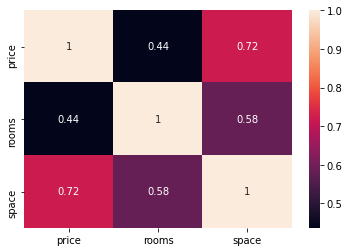

In [85]:
sns.heatmap(df.corr(),annot=True)

From the above correlation matrix we can see that there is no correlation between the feature 'rooms' and the feature 'price', that can be because at it's core the feature 'rooms' is a categorical feature. In the same time we can see that there is a slightly correlation between the features 'rooms' and 'space', but because it is not a strong correlation I consider that we don't have a case of multicollinearity.

In [86]:
df.dtypes

floor            object
neighborhood     object
new_building     object
partitioning     object
price           float64
rooms             int32
space           float64
dtype: object

For doing visual analysis on my features I'm going to split them in categorical and continuous features. 

In [91]:
categorical_features = ['floor', 'neighborhood', 'new_building', 'partitioning', 'rooms']

In [93]:
continuous_features = [feature for feature in df.columns if df[feature].dtypes == 'float']
continuous_features

['price', 'space']

#### Distribution of continuous features

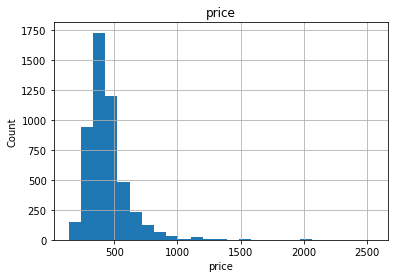

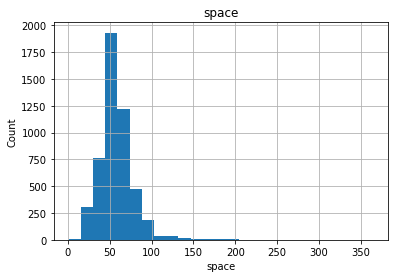

In [94]:
for feature in continuous_features:
    data=df.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

From te above histogram we can see that both continuous features are normally distributed.

#### Relationship between contonuous features and price

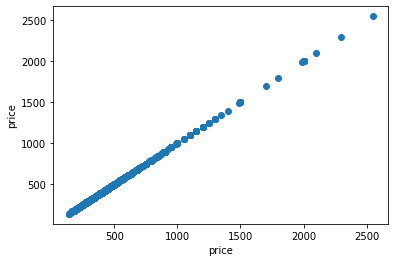

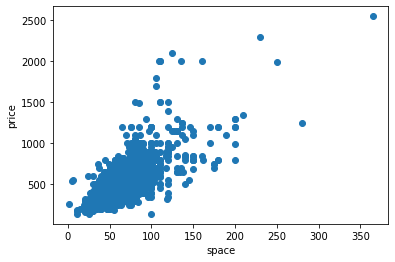

In [95]:
for feature in continuous_features:
    data=df.copy()
    plt.scatter(data[feature],data['price'])
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.show()

From the relationship between the features 'space' and 'price' we can see that they are positive correlated.

#### Relationship between categorical features and price

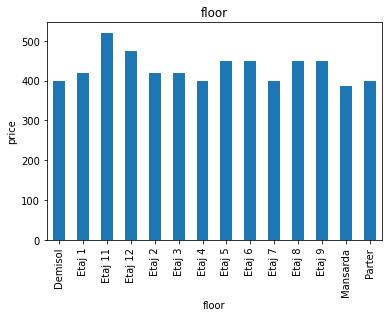

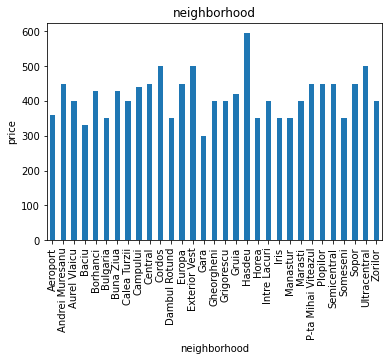

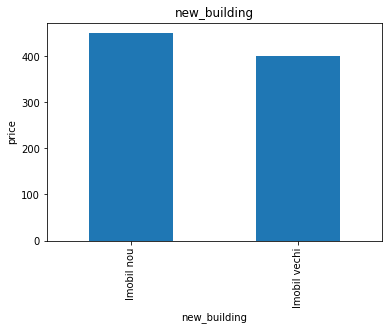

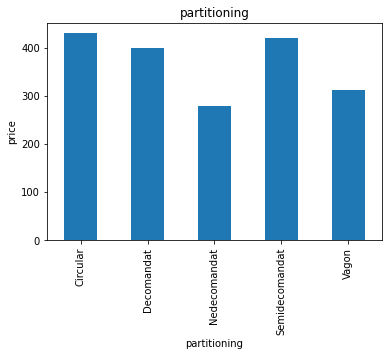

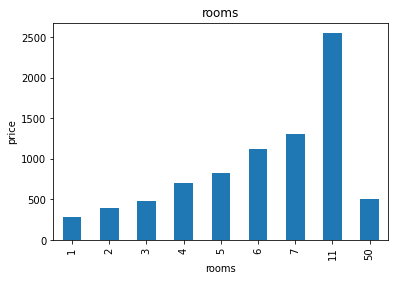

In [96]:
for feature in categorical_features:
    data=df.copy()
    data.groupby(feature)['price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

## 2. Feature Engineering

For my outlier removal I'm going to create a new feature that represents the price per square foot for each apartment in the data set.

In [97]:
df['price_per_square_foot'] = df['price'] / df['space']
df.head()

,floor,neighborhood,new_building,partitioning,price,rooms,space,price_per_square_foot
0,Etaj 5,Central,Imobil vechi,Semidecomandat,400.0,2,58.5,6.837607
1,Demisol,Manastur,Imobil vechi,Semidecomandat,280.0,2,52.0,5.384615
2,Etaj 3,Zorilor,Imobil nou,Semidecomandat,400.0,3,84.0,4.761905
3,Parter,Gheorgheni,Imobil vechi,Semidecomandat,400.0,3,65.0,6.153846
4,Etaj 1,Zorilor,Imobil nou,Decomandat,420.0,2,55.0,7.636364


First I'm going to to see the number of neighborhoods and those neighborhoods from my data set in which I have less than 10 apratments I'm going to save them in one general variable called 'Other neighborhoods'. 

In [98]:
number_apartaments_neighborhood = df['neighborhood'].value_counts()
number_apartaments_neighborhood

Gheorgheni             855
Central                765
Marasti                720
Zorilor                559
Manastur               546
Buna Ziua              255
Grigorescu             185
Semicentral            159
Intre Lacuri           155
Andrei Muresanu        125
Europa                 109
Plopilor               107
Ultracentral            95
Iris                    56
P-ta Mihai Viteazul     53
Borhanci                47
Calea Turzii            36
Gruia                   27
Gara                    26
Sopor                   26
Horea                   19
Dambul Rotund           17
Someseni                15
Hasdeu                  14
Bulgaria                10
Aurel Vlaicu             7
Campului                 6
Aeroport                 4
Baciu                    2
Exterior Vest            1
Cordos                   1
Name: neighborhood, dtype: int64

In [99]:
len(number_apartaments_neighborhood[number_apartaments_neighborhood < 10])

6

In [100]:
location_neighborhood_below_10 = number_apartaments_neighborhood[number_apartaments_neighborhood < 10]
location_neighborhood_below_10

Aurel Vlaicu     7
Campului         6
Aeroport         4
Baciu            2
Exterior Vest    1
Cordos           1
Name: neighborhood, dtype: int64

In [101]:
df['neighborhood'] = df['neighborhood'].apply(lambda x: 'Other neighborhoods' if x in location_neighborhood_below_10 else x)
len(df['neighborhood'].unique())

26

#### Outlier Removal

In romanian legislation for constructions there is stated that a living room should have 18 sqr ft and a bedroom 12 sqr ft.

In this case I will consider as 12 sqr ft a minimum measurement for a room.

I wanted to choose the smaller number because in old buildings made in the communist period the bedrooms of the apartments were smaller per square footage. 

In [102]:
df[df.space/df.rooms<12]

,floor,neighborhood,new_building,partitioning,price,rooms,space,price_per_square_foot
72,Parter,Borhanci,Imobil nou,Decomandat,540.0,2,5.0,108.000000
1023,Parter,Gheorgheni,Imobil vechi,Semidecomandat,180.0,1,11.0,16.363636
1027,Etaj 5,Gheorgheni,Imobil vechi,Decomandat,500.0,50,50.0,10.000000
1744,Etaj 3,Marasti,Imobil nou,Decomandat,550.0,2,6.0,91.666667
2507,Etaj 3,Marasti,Imobil vechi,Decomandat,265.0,1,1.0,265.000000
3777,Etaj 4,Gheorgheni,Imobil vechi,Semidecomandat,189.0,1,11.0,17.181818
4532,Parter,Gheorgheni,Imobil vechi,Semidecomandat,145.0,1,11.0,13.181818


I will chose the ones with the square footage below 11 because based on my experience I know that there are room apartments with only 11 square footage.

In [103]:
df[df.space/df.rooms<11]

,floor,neighborhood,new_building,partitioning,price,rooms,space,price_per_square_foot
72,Parter,Borhanci,Imobil nou,Decomandat,540.0,2,5.0,108.000000
1027,Etaj 5,Gheorgheni,Imobil vechi,Decomandat,500.0,50,50.0,10.000000
1744,Etaj 3,Marasti,Imobil nou,Decomandat,550.0,2,6.0,91.666667
2507,Etaj 3,Marasti,Imobil vechi,Decomandat,265.0,1,1.0,265.000000


In [104]:
df.shape

(5002, 8)

In [105]:
# We are going to remove them
df[df.space/df.rooms<11].index.to_list()

[72, 1027, 1744, 2507]

In [106]:
df.drop([72, 1027, 1744, 2507], inplace=True)

In [107]:
df.shape

(4998, 8)

In [108]:
df.price_per_square_foot.describe()

count    4998.000000
mean        7.870048
std         1.991389
min         1.400000
25%         6.508311
50%         7.538462
75%         8.846154
max        25.000000
Name: price_per_square_foot, dtype: float64

I'm going to group the price square foot by neighborhood and determine the mean and standard deviation of the price per square foot for each neighborhood group. After that I'm going to remove the apartments from the dataset that have the price per square foot fall over and under tree standard deviations away from the mean.

In [109]:
def remove_outliers_ppsf(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('neighborhood'):
        mean = np.mean(subdf.price_per_square_foot)
        std = np.std(subdf.price_per_square_foot)
        reduced_df = subdf[(subdf.price_per_square_foot > (mean-3*std)) & (subdf.price_per_square_foot <= (mean+3*std))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out
                            
df = remove_outliers_ppsf(df)
df.shape

(4949, 8)

Next for each category of neighborhood I'm going to extract the data by the number of rooms, for the most frequent ones, and plot the space and price per square foot for each category of apartments by rooms.

The aim is to see if there are outliers between the price per square footage and total square footage or space of the rooms. Meanning if, for example, there are prices per square footage of apartments with 2 rooms that are less than the apartments with 1 room. 

In [110]:
def scatter_plot_chart(df, neighborhood):
    room_1 = df[(df['neighborhood'] == neighborhood) & (df['rooms']==1)]
    rooms_2 = df[(df['neighborhood'] == neighborhood) & (df['rooms']==2)]
    rooms_3 = df[(df['neighborhood'] == neighborhood) & (df['rooms']==3)]
    rooms_4 = df[(df['neighborhood'] == neighborhood) & (df['rooms']==4)]
    plt.rcParams['figure.figsize'] = (10,10)
    plt.scatter(room_1.space, room_1.price_per_square_foot, marker = '*', color='purple', label='1 room', s=50)
    plt.scatter(rooms_2.space, rooms_2.price_per_square_foot, marker='d', color='blue', label='2 rooms', s=50)
    plt.scatter(rooms_3.space, rooms_3.price_per_square_foot, marker = 'o', color='green', label='3 rooms', s=50)
    plt.scatter(rooms_4.space, rooms_4.price_per_square_foot, marker= '.', color='red', label='4 rooms', s=50)
    plt.xlabel('Total square foot of space')
    plt.ylabel('Price per square foot')
    plt.title(neighborhood)
    plt.legend()

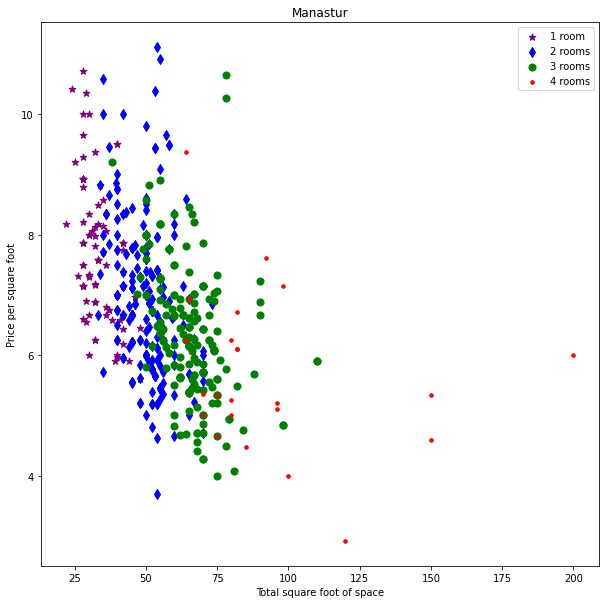

In [111]:
scatter_plot_chart(df, 'Manastur')  

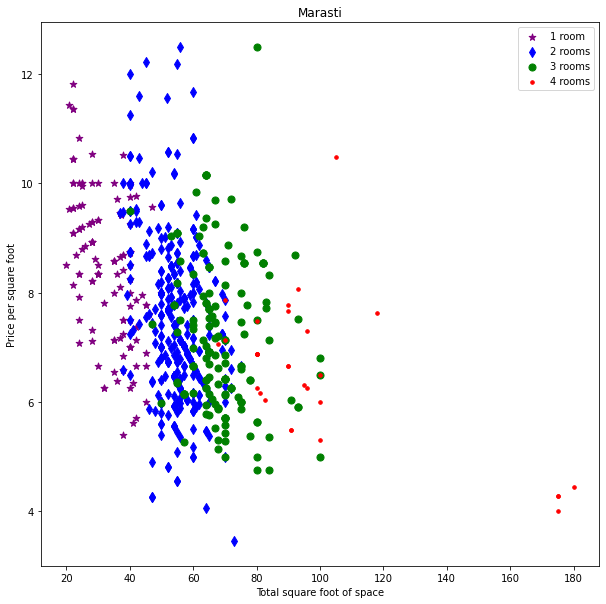

In [112]:
scatter_plot_chart(df, 'Marasti')   

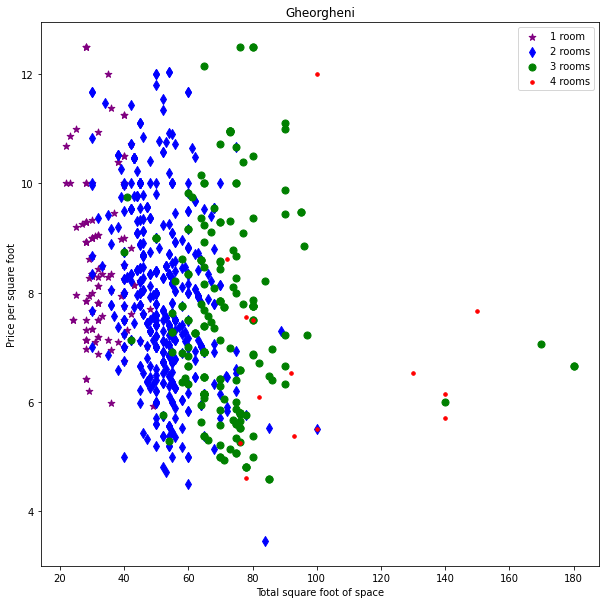

In [113]:
scatter_plot_chart(df, 'Gheorgheni')    

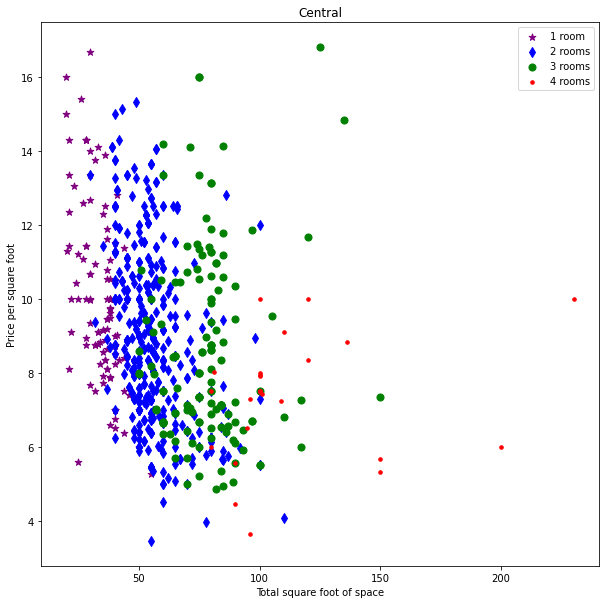

In [114]:
scatter_plot_chart(df, 'Central')   

Below I'm going to remove the outliers identified above.

In [115]:
def remove_rooms_outliers(df):
    exclude_indices = np.array([])
    for neighborhood, neighborhood_df in df.groupby('neighborhood'):
        rooms_stats = {}
        for rooms, rooms_df in neighborhood_df.groupby('rooms'):
            rooms_stats[rooms] = {
                'mean': np.mean(rooms_df.price_per_square_foot),
                'std': np.std(rooms_df.price_per_square_foot),
                'count': rooms_df.shape[0]
            }
        for rooms, rooms_df in neighborhood_df.groupby('rooms'):
            stats = rooms_stats.get(rooms-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, rooms_df[rooms_df.price_per_square_foot<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

df = remove_rooms_outliers(df)
df.shape

(2201, 8)

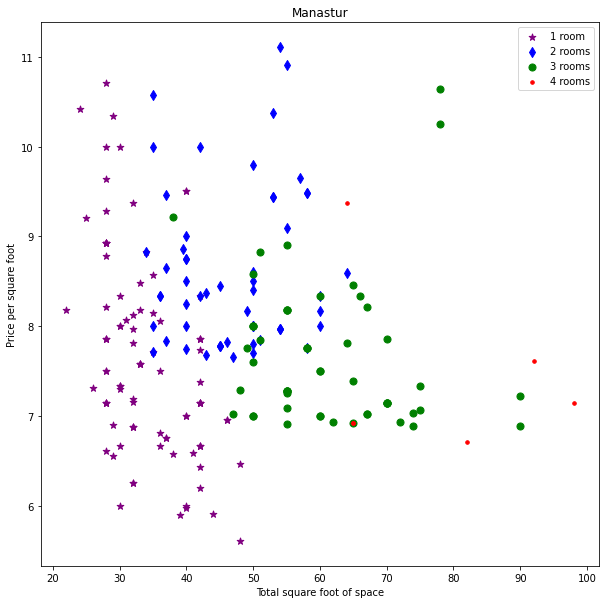

In [116]:
scatter_plot_chart(df, 'Manastur')    

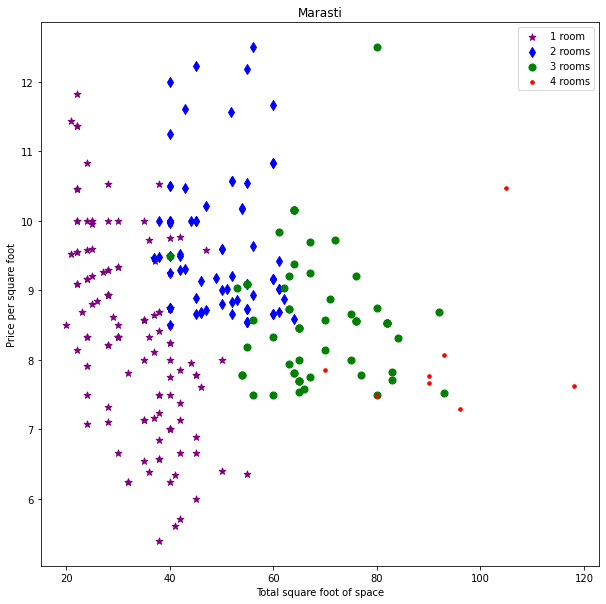

In [117]:
scatter_plot_chart(df, 'Marasti')   

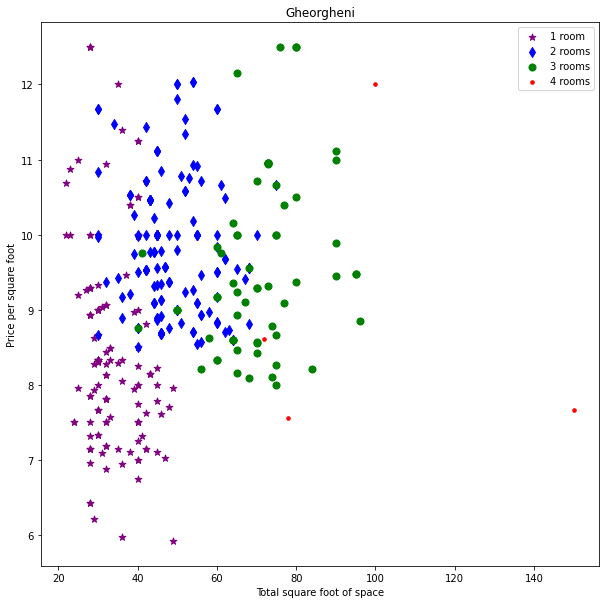

In [118]:
scatter_plot_chart(df, 'Gheorgheni') 

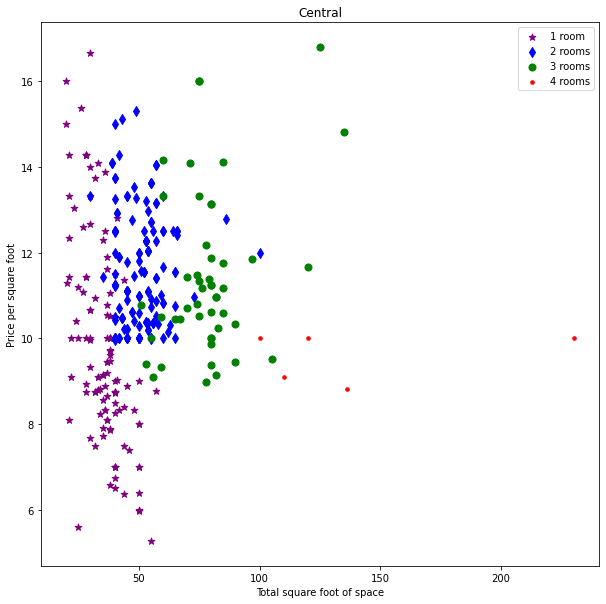

In [119]:
scatter_plot_chart(df, 'Central')   

After I used 'price_per_square_foot' feature for removung outliers, I'm going to drop it. 

In [120]:
df = df.drop(['price_per_square_foot'],axis='columns')
df.head()

,floor,neighborhood,new_building,partitioning,price,rooms,space
2,Etaj 1,Andrei Muresanu,Imobil vechi,Circular,1990.0,4,250.0
5,Parter,Andrei Muresanu,Imobil nou,Semidecomandat,2000.0,4,160.0
6,Etaj 2,Andrei Muresanu,Imobil vechi,Semidecomandat,470.0,2,63.0
7,Etaj 3,Andrei Muresanu,Imobil nou,Decomandat,475.0,2,65.0
8,Demisol,Andrei Muresanu,Imobil vechi,Semidecomandat,400.0,2,44.0


#### Use One Hot Encoding For The Features: 'neighborhood', 'rooms', 'floor', 'new Building' and 'partitioning'

In [121]:
dummies_neighborhood = pd.get_dummies(df['neighborhood']) 
dummies_neighborhood.head()

,Andrei Muresanu,Borhanci,Bulgaria,Buna Ziua,Calea Turzii,Central,Dambul Rotund,Europa,Gara,Gheorgheni,...,Manastur,Marasti,Other neighborhoods,P-ta Mihai Viteazul,Plopilor,Semicentral,Someseni,Sopor,Ultracentral,Zorilor
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
dummies_rooms = pd.get_dummies(df['rooms']) 
dummies_rooms.head()

,1,2,3,4,5,6,7,11
2,0,0,0,1,0,0,0,0
5,0,0,0,1,0,0,0,0
6,0,1,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0


In [123]:
dummies_floor = pd.get_dummies(df['floor']) 
dummies_floor.head()

,Demisol,Etaj 1,Etaj 11,Etaj 2,Etaj 3,Etaj 4,Etaj 5,Etaj 6,Etaj 7,Etaj 8,Etaj 9,Mansarda,Parter
2,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0


In [124]:
dummies_new_building = pd.get_dummies(df['new_building']) 
dummies_new_building.head()

,Imobil nou,Imobil vechi
2,0,1
5,1,0
6,0,1
7,1,0
8,0,1


In [125]:
dummies_partitioning = pd.get_dummies(df['partitioning']) 
dummies_partitioning.head()

,Circular,Decomandat,Nedecomandat,Semidecomandat,Vagon
2,1,0,0,0,0
5,0,0,0,1,0
6,0,0,0,1,0
7,0,1,0,0,0
8,0,0,0,1,0


In [127]:
df = pd.concat([df,dummies_neighborhood.drop('Other neighborhoods', axis='columns'), dummies_new_building, dummies_partitioning, dummies_rooms,dummies_floor], axis='columns') 
df.head()

,floor,neighborhood,new_building,partitioning,price,rooms,space,Andrei Muresanu,Borhanci,Bulgaria,...,Etaj 2,Etaj 3,Etaj 4,Etaj 5,Etaj 6,Etaj 7,Etaj 8,Etaj 9,Mansarda,Parter
2,Etaj 1,Andrei Muresanu,Imobil vechi,Circular,1990.0,4,250.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Parter,Andrei Muresanu,Imobil nou,Semidecomandat,2000.0,4,160.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,Etaj 2,Andrei Muresanu,Imobil vechi,Semidecomandat,470.0,2,63.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
7,Etaj 3,Andrei Muresanu,Imobil nou,Decomandat,475.0,2,65.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
8,Demisol,Andrei Muresanu,Imobil vechi,Semidecomandat,400.0,2,44.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
df = df.drop(['neighborhood', 'new_building', 'partitioning', 'rooms', 'floor'], axis='columns') 
df.head()

,price,space,Andrei Muresanu,Borhanci,Bulgaria,Buna Ziua,Calea Turzii,Central,Dambul Rotund,Europa,...,Etaj 2,Etaj 3,Etaj 4,Etaj 5,Etaj 6,Etaj 7,Etaj 8,Etaj 9,Mansarda,Parter
2,1990.0,250.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2000.0,160.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,470.0,63.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,475.0,65.0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,400.0,44.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Building the model

In [129]:
df.shape

(2201, 87)

In [130]:
X = df.drop(['price'],axis='columns')
X.head()

,space,Andrei Muresanu,Borhanci,Bulgaria,Buna Ziua,Calea Turzii,Central,Dambul Rotund,Europa,Gara,...,Etaj 2,Etaj 3,Etaj 4,Etaj 5,Etaj 6,Etaj 7,Etaj 8,Etaj 9,Mansarda,Parter
2,250.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,160.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,63.0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,65.0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,44.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
X.shape

(2201, 86)

In [132]:
y = df.price
y.head()

2    1990.0
5    2000.0
6     470.0
7     475.0
8     400.0
Name: price, dtype: float64

In [133]:
len(y)

2201

In [134]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=15)

In [135]:
from sklearn.linear_model import LinearRegression

In [137]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression()

In [138]:
linear_regression.score(X_test, y_test)

0.8552424538713835

### Use K Fold cross validation to measure accuracy of our LinearRegression model

In [139]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits = 5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82078735, 0.83773153, 0.81736773, 0.82497372, 0.89350727])

### Test the model for few properties

In [141]:
def predict_price(neighborhood,partitioning, new_building, space,floor,rooms):    
    loc_index = np.where(X.columns==neighborhood)[0][0]
    loc_index1 = np.where(X.columns==partitioning)[0][0]
    loc_index2 = np.where(X.columns==new_building)[0][0]
    loc_index3 = np.where(X.columns==rooms)[0][0]
    loc_index4 = np.where(X.columns==floor)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = space
    if loc_index >= 0 and loc_index1 >= 0 and loc_index2 >= 0 and loc_index3 >= 0 and loc_index4 >= 0:
        x[loc_index] = 1
        x[loc_index1] = 1
        x[loc_index2] = 1
        x[loc_index3] = 1
        x[loc_index4] = 1
        
    return linear_regression.predict([x])[0]

In [142]:
predict_price('Marasti', 'Semidecomandat', 'Imobil vechi', 28,'Etaj 2',1)

221.72144274564005

In [143]:
predict_price('Andrei Muresanu', 'Circular', 'Imobil vechi', 250, 'Parter', 4)

2178.423250411379

In [144]:
predict_price('Central', 'Semidecomandat', 'Imobil vechi', 50, 'Etaj 5', 2)

534.1340991641929

In [145]:
predict_price('Manastur','Semidecomandat', 'Imobil vechi',45,'Etaj 8', 2)

447.2260898384801

In [146]:
predict_price('Marasti', 'Semidecomandat', 'Imobil vechi', 40,'Etaj 2',2)

376.9538011388431

#### Export the model to a pickle file

In [148]:
import pickle
with open('cluj_napoca_rent_price_model.pickle','wb') as f:
    pickle.dump(linear_regression,f)

#### Export location and column information to a file that will be used in the prediction application

In [171]:
import json
columns = {
    'data_columns' : [col for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))